# Chapter 20. 전이 학습을 통해 딥러닝의 성능 극대화하기





In [10]:
import sys
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, LSTM, Conv1D, MaxPooling1D, Activation, BatchNormalization, LeakyReLU, UpSampling2D, Reshape, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import mnist, reuters, imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

print(f"python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"tensorflow: {tf.__version__}")

python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy: 1.25.2
pandas: 1.5.3
sklearn: 1.2.2
matplotlib: 3.7.1
seaborn: 0.13.1
tensorflow: 2.15.0


In [2]:
!git clone https://github.com/taehojo/data-ch20.git

Cloning into 'data-ch20'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 265 (delta 0), reused 265 (delta 0), pack-reused 0
Receiving objects: 100% (265/265), 1.86 MiB | 12.79 MiB/s, done.


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )

In [5]:
train_generator = train_datagen.flow_from_directory(
       './data-ch20/train',   # 학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋은 이미지 부풀리기 과정을 진행하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       './data-ch20/test',   # 테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                   

In [8]:
# 모델 실행의 옵션을 설정합니다.
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다
history = model.fit(
       train_generator,
       epochs=100,
       validation_data=test_generator,
       validation_steps=10,
       callbacks=[early_stopping_callback])

Epoch 1/100
32/32 [==============================] - 8s 184ms/step - loss: 0.7049 - accuracy: 0.5125 - val_loss: 0.7005 - val_accuracy: 0.4000
Epoch 2/100
32/32 [==============================] - 7s 219ms/step - loss: 0.6969 - accuracy: 0.5437 - val_loss: 0.6844 - val_accuracy: 0.5400
Epoch 3/100
32/32 [==============================] - 6s 195ms/step - loss: 0.6894 - accuracy: 0.5250 - val_loss: 0.6827 - val_accuracy: 0.5800
Epoch 4/100
32/32 [==============================] - 5s 164ms/step - loss: 0.6780 - accuracy: 0.5813 - val_loss: 0.6657 - val_accuracy: 0.7000
Epoch 5/100
32/32 [==============================] - 5s 157ms/step - loss: 0.6626 - accuracy: 0.6187 - val_loss: 0.6458 - val_accuracy: 0.7200
Epoch 6/100
32/32 [==============================] - 6s 201ms/step - loss: 0.6442 - accuracy: 0.6750 - val_loss: 0.6249 - val_accuracy: 0.7400
Epoch 7/100
32/32 [==============================] - 5s 170ms/step - loss: 0.5808 - accuracy: 0.7812 - val_loss: 0.5258 - val_accuracy: 0.8400

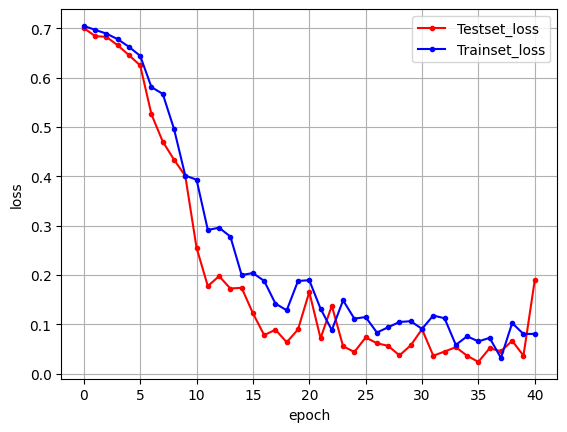

In [9]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [11]:
# VGG16 모델을 불러옵니다.
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

# 우리의 모델을 설정합니다.
finetune_model = Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [13]:
# 모델의 실행 옵션을 설정합니다.
finetune_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=test_generator,
       validation_steps=10,
       callbacks=[early_stopping_callback])

Epoch 1/20
32/32 [==============================] - 54s 2s/step - loss: 0.6905 - accuracy: 0.5875 - val_loss: 0.5340 - val_accuracy: 0.7800
Epoch 2/20
32/32 [==============================] - 61s 2s/step - loss: 0.5746 - accuracy: 0.6938 - val_loss: 0.4230 - val_accuracy: 0.9400
Epoch 3/20
32/32 [==============================] - 62s 2s/step - loss: 0.4248 - accuracy: 0.8313 - val_loss: 0.4127 - val_accuracy: 0.8400
Epoch 4/20
32/32 [==============================] - 60s 2s/step - loss: 0.4015 - accuracy: 0.8438 - val_loss: 0.3987 - val_accuracy: 0.8800
Epoch 5/20
32/32 [==============================] - 59s 2s/step - loss: 0.3871 - accuracy: 0.8687 - val_loss: 0.3140 - val_accuracy: 0.9400
Epoch 6/20
32/32 [==============================] - 59s 2s/step - loss: 0.3174 - accuracy: 0.8813 - val_loss: 0.2713 - val_accuracy: 0.9400
Epoch 7/20
32/32 [==============================] - 59s 2s/step - loss: 0.2846 - accuracy: 0.9187 - val_loss: 0.2858 - val_accuracy: 0.8600
Epoch 8/20
32/32 [==

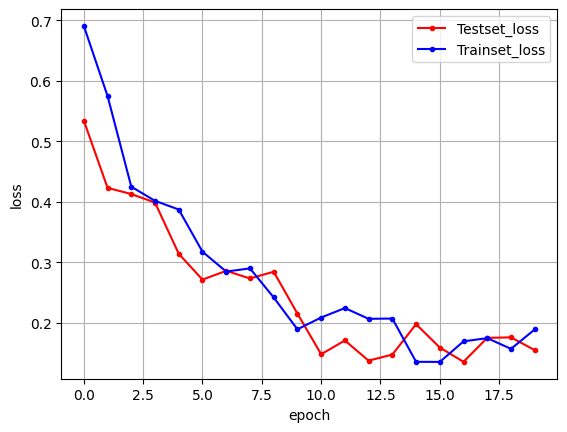

In [14]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()